In [1]:
import os, glob
import pandas as pd
import numpy as np
from utils import print_messages, load_data
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset#, Features, Value, ClassLabel
import json
import datasets
from pathlib import Path
from datasets import load_dataset, DatasetDict, Dataset, NamedSplit
import matplotlib.pyplot as plt


In [2]:
task = 'd'
ds = load_dataset(f'nlpUc3mStudents/mental-risk-{task}')
# to pandas
train_df = ds['train'].to_pandas()
test_df = ds['test'].to_pandas()
label_names = train_df.iloc[:,4:].columns.tolist()
# concat messages by subject id
train_by_subjectid = (
    train_df.groupby('subject_id')
    .agg({'message': lambda x: ' | '.join(x), **{col: 'first' for col in label_names}})
    .reset_index()
)
test_by_subjectid = (
    test_df.groupby('subject_id')
    .agg({'message': lambda x: ' | '.join(x), **{col: 'first' for col in label_names}})
    .reset_index()
)
data = pd.concat([train_by_subjectid, test_by_subjectid], axis=0)
dataset = Dataset.from_pandas(data)

Found cached dataset parquet (/Users/simon/.cache/huggingface/datasets/nlpUc3mStudents___parquet/nlpUc3mStudents--mental-risk-d-f86708bb810ba078/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Show if there's imbalance with respect to probabilities of each class greater than the rest

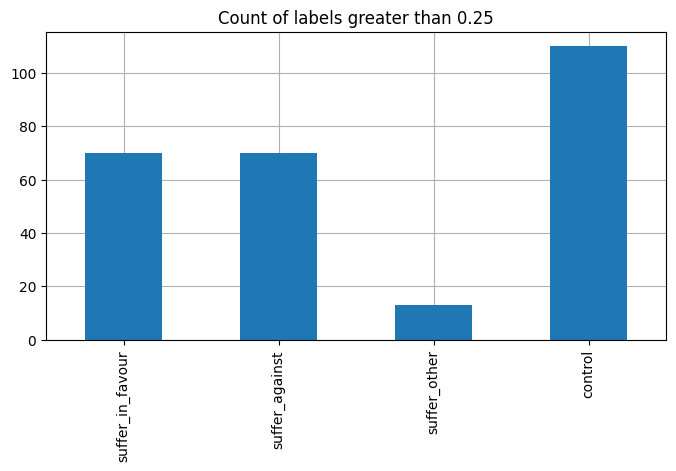

In [15]:
# count of labels greater then a threshold
th = 0.25
label_counts = data.loc[:,label_names].apply(lambda x: (x > th).sum(), axis=0, result_type='reduce')
ax = label_counts.plot.bar(figsize=(8,4), title=f'Count of labels greater than {th}', zorder=2)
ax.grid()
plt.show()

### Using Embeddings for Text Classification/Regression

The plan is to first use the embeddings to get a set of features for each text. Then we will use these features to train a classifier/regressor such as a Random Forest or a XGBoost model.

In [3]:
# Embeddings
from sentence_transformers import SentenceTransformer

# train a classifier on the embeddings for multiclass regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, mean_squared_error,  # regression metrics
    accuracy_score, f1_score, precision_score, recall_score # classification metrics
)
from sklearn.multioutput import MultiOutputRegressor # for multiclass regression

# Estimators
from sklearn.ensemble import (
    RandomForestRegressor, 
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
    AdaBoostRegressor,
    AdaBoostClassifier
)
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
    Ridge,
    Lasso
)
# other regressors
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

# type hinting
from typing import List, Callable, Dict, Tuple, Any

def comp_score(y_true:np.ndarray,y_pred:np.ndarray)->float:
    """
    Metric for multiclass regression. Computes the average of the RMSE scores for each label.
    """
    rmse_scores = []
    for i in range(len(label_names)):
        rmse_scores.append(np.sqrt(mean_squared_error(y_true[:,i],y_pred[:,i])))
    return np.mean(rmse_scores)

def estimators_eval(estimators:List[Tuple[str,Any]], score_func:Callable[[np.ndarray, np.ndarray], float]):
    def fit_eval_estimators(X_train:np.ndarray, y_train:np.ndarray, X_test:np.ndarray, y_test:np.ndarray) -> dict:
        estimator_scores = {}
        for name, estimator in estimators:
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            score = score_func(y_test, y_pred)*(1.4*((y_train>th).sum()/(len(y_train)-1))) # weighted for class imbalance
            print(f"\"{name}\" estimator score: {score:.4f}")
            estimator_scores[name] = score
        return estimator_scores
    return fit_eval_estimators


In [4]:
# get embeddings
model_name= 'hackathon-somos-nlp-2023/roberta-base-bne-finetuned-suicide-es'
model = SentenceTransformer(model_name) # note: SentenceTransformer from BERTforSequenceClassification (will throw a warning)
embeddings = model.encode(data['message'].values.tolist())
os.environ["TOKENIZERS_PARALLELISM"] = "false"

No sentence-transformers model found with name /Users/simon/.cache/torch/sentence_transformers/hackathon-somos-nlp-2023_roberta-base-bne-finetuned-suicide-es. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/simon/.cache/torch/sentence_transformers/hackathon-somos-nlp-2023_roberta-base-bne-finetuned-suicide-es were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# split data evenly
Y = data.iloc[:, 2:].values.astype(np.float32)
labels_to_num_dict = json.load(open('labels_to_num_dict.json'))
classes = data.iloc[:,2:].apply(lambda x: x.argmax(),axis=1).replace(dict(enumerate(data.iloc[:,2:].columns)))
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, 
    test_size=0.15, 
    random_state=42, 
    stratify=classes
)
X_train.shape, X_test.shape

((157, 768), (28, 768))

"LinearRegression" estimator score: 0.4689
"RandomForestRegressor" estimator score: 0.3693
"LGBMRegressor" estimator score: 0.3512
"GradientBoostingRegressor" estimator score: 0.3680
"AdaBoostRegressor" estimator score: 0.3571
"SVR" estimator score: 0.3578
"KNeighborsRegressor" estimator score: 0.3995
"MLPRegressor" estimator score: 0.3854
"DecisionTreeRegressor" estimator score: 0.5083
"Lasso" estimator score: 0.4944
"Ridge" estimator score: 0.3565


<Axes: title={'center': 'Multi-Regression Scores (lower is better)'}>

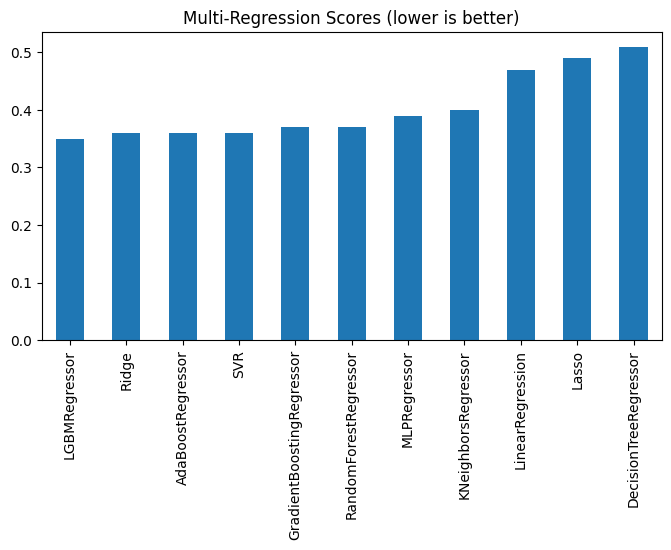

In [47]:
# estimators for multi-regression
regressors = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=500),
    LGBMRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(),
    DecisionTreeRegressor(),
    Lasso(),
    Ridge()
]
multi_regressors = [(reg.__class__.__name__, MultiOutputRegressor(reg)) for reg in regressors]
fit_eval = estimators_eval(multi_regressors, comp_score)
results = fit_eval(X_train, y_train, X_test, y_test)
results_df = pd.DataFrame({reg:[score] for reg,score in results.items()}).T.rename(columns={0:'score'}).sort_values('score',ascending=True)
results_df.round(2).plot.bar(figsize=(8,4), title='Multi-Regression Scores (lower is better)', legend=False)

In [10]:
from functools import partial
# calculate metrics 

def label_metrics(score_fun, y_true, y_pred):
    scores = []
    for i in range(len(label_names)):
        scores.append(score_fun(y_true[:,i],y_pred[:,i]))
    return scores

def metrics_for_estimators(estimators, score_fun):
    metrics = {}
    for name, estimator in estimators:
        y_pred = scale_probabilities(estimator.predict(X_test))
        metrics[name] = label_metrics(score_fun, y_test, y_pred)
    return metrics

r2_metrics = metrics_for_estimators(multi_regressors, r2_score)
rmse_metrics = metrics_for_estimators(multi_regressors, partial(mean_squared_error, squared=False))

r2_df = pd.DataFrame(r2_metrics, index=label_names).loc[:,results_df.index.tolist()].T.rename_axis('r2_class', axis=1)
rmse_df = pd.DataFrame(rmse_metrics, index=label_names).loc[:,results_df.index.tolist()].T.rename_axis('rmse_class', axis=1)
display(r2_df)
display(rmse_df)
# r2	suffer_in_favour	suffer_against	suffer_other	control
# ada	0.409629	0.286069	-0.053885	0.733138
# lgbm	0.407256	0.315252	-0.286333	0.731618
# ridge	0.484130	0.254723	-0.038525	0.670384

In [7]:
# hyperparameter tuning for the 3 best estimators: AdaBoost, LGBM, and Ridge Regression
from sklearn.model_selection import GridSearchCV

def fit_grid(estimator, param_grid):
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print(f"Best score: {grid.best_score_:.4f}")
    return grid.best_estimator_, grid.best_params_

# AdaBoost
ada_params = {
    'estimator__n_estimators': [50, 100, 200, 250, 500],
    'estimator__learning_rate': [0.8, 1.0, 1.5]
}
# LGBM
lgbm_params = {
    'estimator__n_estimators': [50, 100, 200, 500, 1000],
    'estimator__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [3, 5, 7, 9]
}
# Ridge
ridge_params = {
    'estimator__alpha': np.logspace(-1, 2, 15).round(4), # alpha is the 
    'estimator__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
# fit
est_params = [('ada', ada_params, AdaBoostRegressor()), ('lgbm', lgbm_params, LGBMRegressor()), ('ridge', ridge_params, Ridge())]
gs_dict = {}
for name, params, estimator in est_params:
    best_estimator, best_params = fit_grid(MultiOutputRegressor(estimator), params)
    gs_dict[name] = {
        'best_params': best_params,
        'best_estimator': best_estimator
    }
    print(f"Best params for {name.title()}: {best_params}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best score: 0.2708
Best params for Ada: {'estimator__learning_rate': 1.0, 'estimator__n_estimators': 250}
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best score: 0.2225
Best params for Lgbm: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 500}
Fitting 3 folds for each of 105 candidates, totalling 315 fits
Best score: 0.2762
Best params for Ridge: {'estimator__alpha': 3.1623, 'estimator__solver': 'lsqr'}


In [42]:
best_estimators = [(name, gs_dict[name]['best_estimator']) for name in gs_dict.keys()]
r2_metrics_best = metrics_for_estimators(best_estimators, r2_score)
rmse_metrics_best = metrics_for_estimators(best_estimators, partial(mean_squared_error, squared=False))

r2_df_best = pd.DataFrame(r2_metrics_best, index=label_names).T.rename_axis('r2', axis=1)
rmse_df_best = pd.DataFrame(rmse_metrics_best, index=label_names).T.rename_axis('rmse', axis=1)
display(r2_df_best)
display(rmse_df_best)

r2,suffer_in_favour,suffer_against,suffer_other,control
ada,0.409629,0.286069,-0.053885,0.733138
lgbm,0.407256,0.315252,-0.286333,0.731618
ridge,0.484130,0.254723,-0.038525,0.670384


rmse,suffer_in_favour,suffer_against,suffer_other,control
ada,0.213760,0.181662,0.104412,0.206198
lgbm,0.214190,0.177911,0.115353,0.206784
ridge,0.199818,0.185607,0.103648,0.229163


In [12]:
best_estimators = [(name, gs_dict[name]['best_estimator']) for name in gs_dict.keys()]
r2_metrics_best = metrics_for_estimators(best_estimators, r2_score)
rmse_metrics_best = metrics_for_estimators(best_estimators, partial(mean_squared_error, squared=False))

r2_df_best = pd.DataFrame(r2_metrics_best, index=label_names).T.rename_axis('r2', axis=1)
rmse_df_best = pd.DataFrame(rmse_metrics_best, index=label_names).T.rename_axis('rmse', axis=1)
display(r2_df_best)
display(rmse_df_best)

r2,suffer_in_favour,suffer_against,suffer_other,control
ada,0.465327,0.396640,0.030650,0.650707
lgbm,0.528588,0.399890,-0.259651,0.663750
ridge,0.484121,0.254782,-0.038568,0.670378


rmse,suffer_in_favour,suffer_against,suffer_other,control
ada,0.203427,0.167003,0.100137,0.235904
lgbm,0.191014,0.166553,0.114150,0.231458
ridge,0.199820,0.185600,0.103650,0.229165


In [16]:
# make a pipeline to get the embeddings and then predict
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from task_d import EmbeddingsTransformer

# class EmbeddingsTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, encoder):
#         self.encoder = encoder
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X:List[str], y=None):
#         return self.encoder.encode(X)
    
def scale_probabilities(X:np.ndarray):
    """
    Ensures that the probabilities of a vector sum to 1.
    """
    X = X.round(4)
    return X / X.sum(axis=1).reshape(-1, 1)

# get the best params of each and train with all the data
ada_best_params = {k.split('__')[-1]:v for k,v in gs_dict['ada']['best_params'].items()}
lgbm_best_params = {k.split('__')[-1]:v for k,v in gs_dict['lgbm']['best_params'].items()}
ridge_best_params = {k.split('__')[-1]:v for k,v in gs_dict['ridge']['best_params'].items()}

ada_best_estimator = MultiOutputRegressor(AdaBoostRegressor(**ada_best_params))
lgbm_best_estimator = MultiOutputRegressor(LGBMRegressor(**lgbm_best_params))
ridge_best_estimator = MultiOutputRegressor(Ridge(**ridge_best_params))

ada_best_estimator.fit(embeddings, Y)
lgbm_best_estimator.fit(embeddings, Y)
ridge_best_estimator.fit(embeddings, Y)

ada_embedding_pipeline = Pipeline([
    ('embeddings', EmbeddingsTransformer(model)),
    ('estimator', gs_dict['ada']['best_estimator']),
])
ridge_embedding_pipeline = Pipeline([
    ('embeddings', EmbeddingsTransformer(model)),
    ('estimator', gs_dict['ridge']['best_estimator']),
])
lgbm_embedding_pipeline = Pipeline([
    ('embeddings', EmbeddingsTransformer(model)),
    ('estimator', gs_dict['lgbm']['best_estimator']),
])

# save the pipelines
import pickle
pickle.dump(ada_embedding_pipeline, open('embeddings_fe_ada_pipeline.pkl', 'wb'))
pickle.dump(ridge_embedding_pipeline, open('embeddings_fe_ridge_pipeline.pkl', 'wb'))
pickle.dump(lgbm_embedding_pipeline, open('embeddings_fe_lgbm_pipeline.pkl', 'wb'))

No sentence-transformers model found with name /Users/simon/.cache/torch/sentence_transformers/hackathon-somos-nlp-2023_roberta-base-bne-finetuned-suicide-es. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/simon/.cache/torch/sentence_transformers/hackathon-somos-nlp-2023_roberta-base-bne-finetuned-suicide-es were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No sentence-transformers model found

In [15]:
def format_output(X:np.ndarray):
    """
    Formats the output of the model to be a dataframe.
    """
    return pd.DataFrame(scale_probabilities(X), columns=label_names)
out = scale_probabilities(lgbm_embedding_pipeline.predict(['me quiero suicidar', 'me siento muy triste', 'me siento muy feliz']))
print(format_output(out))
out.sum(axis=1)

   suffer_in_favour  suffer_against  suffer_other  control
0            0.3942          0.1218        0.1270   0.3570
1            0.4886          0.1874        0.1399   0.1841
2            0.3335          0.2416        0.1586   0.2663


array([1., 1., 1.])

In [ ]:
# show that it works
# load the pipeline
import pickle
pipe = pickle.load(open('embeddings_fe_ada_pipeline.pkl', 'rb'))

# get small sample of data
sample_inds = np.random.choice(range(len(data)), 50, replace=False)
y_pred_sample = pipe.predict(data.iloc[sample_inds]['message'].tolist())
y_test_sample = data.iloc[sample_inds][label_names].values

# evaluate
r2 = r2_score(y_test_sample, y_pred_sample, multioutput='raw_values')
rmse = mean_squared_error(y_test_sample, y_pred_sample, squared=False, multioutput='raw_values')
print("Labels:", label_names)
print(f"R2: {r2}")
print(f"RMSE: {rmse}")

In [ ]:
# save the best estimators
import pickle
for name, estimator in best_estimators:
    with open(f'{name}_estimator.pkl', 'wb') as f:
        pickle.dump(estimator, f)

In [71]:
# evaluate which consumes the least energy
from codecarbon import EmissionsTracker
import time
tracker_config = {
    "save_to_file": True,
    "log_level": "DEBUG",
    "tracking_mode": "process",
    "output_dir": ".", 
}
tracker = EmissionsTracker(**tracker_config)
emissions_dict = {}
for name, estimator in best_estimators:
    tracker.start()
    tstart = time.time()
    # embeddings = model.encode(data['message'].values.tolist())
    y_pred = estimator.predict(embeddings)
    time_taken = time.time() - tstart
    emissions_dict[name] = {'emmisions': tracker.stop()}
    emissions_dict[name]['time_taken'] = time_taken


[codecarbon INFO @ 15:27:33] [setup] RAM Tracking...
[codecarbon INFO @ 15:27:33] [setup] GPU Tracking...
[codecarbon INFO @ 15:27:33] No GPU found.
[codecarbon INFO @ 15:27:33] [setup] CPU Tracking...
[codecarbon DEBUG @ 15:27:33] Not using PowerGadget, an exception occurred while instantiating IntelPowerGadget : Intel Power Gadget executable not found on darwin
[codecarbon DEBUG @ 15:27:33] Not using the RAPL interface, an exception occurred while instantiating IntelRAPL : Platform not supported by Intel RAPL Interface
[codecarbon WARNING @ 15:27:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon DEBUG @ 15:27:33] CPU : We detect a Apple M1 Pro with a TDP of 10 W
[codecarbon INFO @ 15:27:33] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 15:27:33] >>> Tracker's metadata:
[codecarbon INFO @ 15:27:33]   Platform system: macOS-13.0-arm64-arm-64bit
[codecarbon INFO @ 15:27:33]   Python version: 3.8.16
[codecarbon INFO @ 15:27:33]   Cod

With PCA (Principal Component Analysis):

In [43]:
# with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape, X_test_pca.shape)

X_train = X_train_pca
X_test = X_test_pca

(157, 67) (28, 67)


In [44]:
def fit_grid_pca(estimator, param_grid):
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=3,
        verbose=1,
        n_jobs=-1
    )
    grid.fit(X_train_pca, y_train)
    print(f"Best score: {grid.best_score_:.4f}")
    return grid.best_estimator_, grid.best_params_

gs_dict = {}
for name, params, estimator in est_params:
    best_estimator, best_params = fit_grid_pca(MultiOutputRegressor(estimator), params)
    gs_dict[name] = {'best_params': best_params, 'best_estimator': best_estimator}
    print(f"Best params for {name.title()}: {best_params}")

best_estimators = [(name, gs_dict[name]['best_estimator']) for name in gs_dict.keys()]
r2_metrics_best = metrics_for_estimators(best_estimators, r2_score)
rmse_metrics_best = metrics_for_estimators(best_estimators, partial(mean_squared_error, squared=False))

r2_df_best = pd.DataFrame(r2_metrics_best, index=label_names).T.rename_axis('r2', axis=1)
rmse_df_best = pd.DataFrame(rmse_metrics_best, index=label_names).T.rename_axis('rmse', axis=1)
display(r2_df_best)
display(rmse_df_best)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best score: 0.1511
Best params for Ada: {'estimator__learning_rate': 1.0, 'estimator__n_estimators': 250}
Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best score: 0.1251
Best params for Lgbm: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 50}
Fitting 3 folds for each of 105 candidates, totalling 315 fits
Best score: 0.2748
Best params for Ridge: {'estimator__alpha': 3.1623, 'estimator__solver': 'saga'}


r2,suffer_in_favour,suffer_against,suffer_other,control
ada,0.096638,0.284137,0.045196,0.553737
lgbm,0.107292,0.169964,0.043473,0.539874
ridge,0.479534,0.265964,-0.030321,0.665274


rmse,suffer_in_favour,suffer_against,suffer_other,control
ada,0.264421,0.181908,0.099382,0.266647
lgbm,0.262857,0.195877,0.099472,0.270757
ridge,0.200706,0.184202,0.103238,0.230933
